# Quickstart guide

In this notebook we will through all the steps from downloading the data and training a model to evaluating the results. Check out the `environment.yml` file for the required Python packages.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

## Downloading the data

The data is hosted here. For this guide we will simply download the a year (1997) data.

In [2]:
# To do

## Open the data

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import os

data_dir = "/Volumes/T5/neuralcora-data"

# List all files in the directory
datasets = [f for f in os.listdir(data_dir) if f.endswith(".nc")]
datasets.sort()  # sort for readability

print("Available datasets:")
for ds in datasets:
    print(ds)

Available datasets:
._NY_1998_180_360.nc
._NY_1999_180_360.nc
._NY_2000_180_360.nc
._NY_2001_180_360.nc
._NY_2002_180_360.nc
._NY_2003_180_360.nc
._NY_2004_180_360.nc
._NY_2005_180_360.nc
._NY_2006_180_360.nc
._NY_2007_180_360.nc
._NY_2008_180_360.nc
._NY_2009_180_360.nc
._NY_2010_180_360.nc
._NY_2011_180_360.nc
._NY_2012_180_360.nc
._NY_2013_180_360.nc
._NY_2014_180_360.nc
._NY_2015_180_360.nc
._NY_2016_180_360.nc
._NY_2017_180_360.nc
._NY_2018_180_360.nc
._NY_2019_180_360.nc
._NY_2020_180_360.nc
._NY_2021_180_360.nc
._NY_2022_180_360.nc
._real_land_mask_180_360.nc
NY_1998_180_360.nc
NY_1999_180_360.nc
NY_2000_180_360.nc
NY_2001_180_360.nc
NY_2002_180_360.nc
NY_2003_180_360.nc
NY_2004_180_360.nc
NY_2005_180_360.nc
NY_2006_180_360.nc
NY_2007_180_360.nc
NY_2008_180_360.nc
NY_2009_180_360.nc
NY_2010_180_360.nc
NY_2011_180_360.nc
NY_2012_180_360.nc
NY_2013_180_360.nc
NY_2014_180_360.nc
NY_2015_180_360.nc
NY_2016_180_360.nc
NY_2017_180_360.nc
NY_2018_180_360.nc
NY_2019_180_360.nc
NY_2020_1

In [5]:
mask = xr.open_dataset(f"{data_dir}/real_land_mask_180_360.nc")

In [6]:
import os, glob
import xarray as xr
import pandas as pd
from datetime import timedelta

def _files_for_years(start_year: int, end_year: int):
    """Return existing file paths for years in [start_year, end_year]."""
    files = []
    years = []
    for y in range(start_year, end_year + 1):
        fn = os.path.join(data_dir, f"NY_{y}_180_360.nc")
        if os.path.exists(fn):
            files.append(fn)
            years.append(y)
        else:
            # silently skip missing years (e.g., 1997) but keep going
            pass
    if not files:
        raise FileNotFoundError(f"No yearly files found between {start_year} and {end_year}.")
    return files, years

def _safe_end_of_day(ts: pd.Timestamp) -> pd.Timestamp:
    """If user gave a date without time, extend to end-of-day (inclusive)."""
    if ts.time() == pd.Timestamp(0).time():  # 00:00:00
        # move to 23:59:59.999999999 for inclusive slice
        return ts + pd.Timedelta(days=1) - pd.Timedelta(nanoseconds=1)
    return ts

def parse_period(spec: str):
    """
    Accepts:
      - 'YYYY-YYYY'                (year range)
      - 'YYYYMMDD-YYYYMMDD'        (date range)
      - 'YYYYMMDDHH-YYYYMMDDHH'    (hourly datetimes)
    Returns (start_ts, end_ts).
    """
    spec = spec.strip()
    if "-" not in spec:
        raise ValueError("Period must be a range like '1998-2022' or '19980101-20101231'.")

    left, right = spec.split("-", 1)
    # Year-only range
    if len(left) == 4 and len(right) == 4:
        start = pd.to_datetime(f"{left}-01-01 00:00:00")
        # end of last year: inclusive
        end = pd.to_datetime(f"{right}-12-31 23:59:59")
        return start, end

    # Flexible datetime parsing for day or hour resolution
    # e.g., 19970101, 20101231, 1997010100, 2010123123
    def _parse_side(s):
        if len(s) == 8:    # YYYYMMDD
            return pd.to_datetime(s, format="%Y%m%d")
        elif len(s) == 10: # YYYYMMDDHH
            return pd.to_datetime(s, format="%Y%m%d%H")
        else:
            # Let pandas try, but it's better to be explicit above.
            return pd.to_datetime(s)

    start = _parse_side(left)
    end   = _parse_side(right)
    # Make end inclusive if no explicit time provided
    end = _safe_end_of_day(end)
    return start, end

def open_period(period_spec: str, chunks=None, parallel=False):
    """
    Open hourly data for the requested period, concatenated along time,
    then return the dataset sliced to the exact time window.
    - period_spec examples: '1998-2022', '19970101-20101231', '1998010100-1998123123'
    - chunks: dict for dask chunking, e.g. {'time': 24*30} (optional; requires dask)
    """
    start_ts, end_ts = parse_period(period_spec)
    start_year, end_year = start_ts.year, end_ts.year

    files, _ = _files_for_years(start_year, end_year)

    # Efficient multi-file open: rely on 'time' coords to align
    # If you have dask installed, pass e.g. chunks={'time': 24*30}
    ds = xr.open_mfdataset(
        files,
        combine="by_coords",
        parallel=parallel,
        chunks=chunks
    )

    # Clip to requested time range (inclusive)
    ds = ds.sel(time=slice(start_ts, end_ts))
    if ds.sizes.get("time", 0) == 0:
        raise ValueError(f"No data within requested window {start_ts} to {end_ts}.")
    return ds

In [7]:
# --- Examples ---

# (A) Full-year span (matches what you asked):
# Note: your data starts at 1998; 1997 will be skipped automatically.
TIME_PERIOD = "2018-2022"

ds = open_period(TIME_PERIOD)

# (B) Date span:
# ds = open_period("19970101-20101231")

# (C) Hourly precision:
# ds = open_period("1998010100-1998123123")

# (D) With dask chunking (if dask installed) for better performance:
# ds = open_period("1998-2022", chunks={'time': 24*30}, parallel=True)

In [8]:
print(ds)

<xarray.Dataset> Size: 23GB
Dimensions:    (time: 43824, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 351kB 2018-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25
Data variables:
    zeta       (time, latitude, longitude) float64 23GB dask.array<chunksize=(274, 6, 23), meta=np.ndarray>


In [9]:
# Select: zeta
zeta = (ds["zeta"].sel(time=slice("1998-01-01T00:00:00", "2022-12-31T23:00:00")))

# Quick sanity checks
print(zeta)

<xarray.DataArray 'zeta' (time: 43824, latitude: 180, longitude: 360)> Size: 23GB
dask.array<concatenate, shape=(43824, 180, 360), dtype=float64, chunksize=(275, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 351kB 2018-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25


In [10]:
zeta_val = (ds["zeta"].sel(time=slice("2022-01-01T00:00:00", "2022-12-31T23:00:00")))
zeta_val

<xarray.DataArray 'zeta' (time: 8760, latitude: 180, longitude: 360)> Size: 5GB
dask.array<getitem, shape=(8760, 180, 360), dtype=float64, chunksize=(274, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25

In [11]:
TARGET_VAR = 'zeta'
truth = zeta_val.rename(TARGET_VAR)
truth


<xarray.DataArray 'zeta' (time: 8760, latitude: 180, longitude: 360)> Size: 5GB
dask.array<getitem, shape=(8760, 180, 360), dtype=float64, chunksize=(274, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25

In [12]:
str(zeta.time[0].values)[:19]
# '1998-01-01T00:00:00'

'2018-01-01T00:00:00'

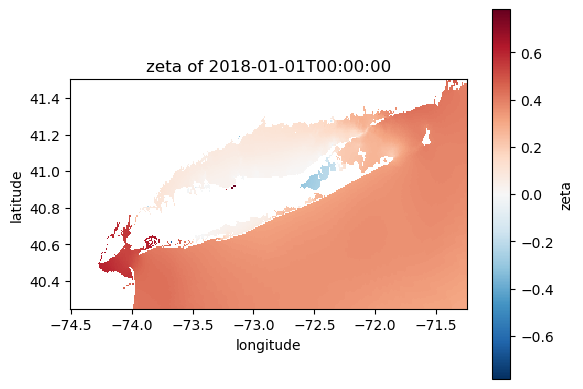

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
qm = zeta.isel(time=0).plot(ax=ax)
ax.set_aspect(1.5)
ax.set_title(f"zeta of {str(zeta.time[0].values)[:19]}")
plt.show()

## Create a simple Persistence forecast

In [14]:
# persistence function from weatherbench (Too slow)

# def create_persistence_forecast(ds, lead_time_h):
#     assert lead_time_h > 0, 'Lead time must be greater than 0'
#     ds_fc = ds.isel(time=slice(0, -lead_time_h))
#     return ds_fc

# lead_times = xr.DataArray(
#     np.arange(1, 8753, 1), dims=['lead_time'], coords={'lead_time': np.arange(1, 8753, 1)}, name='lead_time')

# print(lead_times)

# persistence = []
# valid_data = zeta_val
# for l in lead_times:
#     persistence.append(create_persistence_forecast(valid_data, int(l)))
# persistence = xr.concat(persistence, dim=lead_times)

In [15]:
import numpy as np
import xarray as xr

def persistence_forecast(valid_data: xr.DataArray, max_lead_h: int) -> xr.DataArray:
    """
    valid_data: DataArray with a 'time' dim (hourly)
    max_lead_h: maximum lead in hours (e.g., 8752)

    Returns: DataArray with dims ('lead_time', 'time', ...other dims...),
             where values are the persistence forecast initialized at 'time'
             for each lead_time. Includes a 2D 'valid_time' coord.
    """
    if max_lead_h <= 0:
        raise ValueError("Lead time must be greater than 0")

    # We’ll use the shortest common init-time range so that all leads have a verifying time.
    # If you prefer to keep full length and allow trailing NaNs, see the commented section below.
    init = valid_data.isel(time=slice(0, -max_lead_h))

    # Create lead_time coordinate
    lead_times = xr.DataArray(
        np.arange(1, max_lead_h + 1, dtype=int),
        dims=["lead_time"],
        name="lead_time"
    )

    # Broadcast the init values along lead_time without copying
    # (xarray will lazily broadcast; with dask, this stays lazy)
    fcst = init.expand_dims(lead_time=lead_times)

    # Attach a 2D valid_time coordinate so you can align to observations at t+lead
    # Assumes hourly spacing
    valid_time = xr.DataArray(
        init["time"].values[None, :] + lead_times.values[:, None].astype("timedelta64[h]"),
        dims=("lead_time", "time"),
        name="valid_time"
    )
    fcst = fcst.assign_coords(valid_time=valid_time)

    fcst.name = getattr(valid_data, "name", "persistence")
    return fcst

In [16]:
max_lead = 1
persistence = persistence_forecast(zeta_val, max_lead)
persistence

<xarray.DataArray 'zeta' (lead_time: 1, time: 8759, latitude: 180,
                          longitude: 360)> Size: 5GB
dask.array<getitem, shape=(1, 8759, 180, 360), dtype=float64, chunksize=(1, 274, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * lead_time   (lead_time) int64 8B 1
  * time        (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T22:00:00
  * latitude    (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude   (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25
    valid_time  (lead_time, time) datetime64[ns] 70kB 2022-01-01T01:00:00 ......

### Prepare baseline forecasts

Convert persistence and climatology into time-aligned forecasts so they can be evaluated alongside the observations.


In [17]:
from src.metrics import compute_weighted_rmse


## Create a simple Climatology forecast

In [18]:
def create_climatology_forecast(ds_train, variable=TARGET_VAR):
    """Return the mean climatology for the requested variable.

    If ``ds_train`` is a Dataset, it selects ``variable`` before averaging.
    """
    if isinstance(ds_train, xr.Dataset):
        if variable not in ds_train:
            raise KeyError(f"Variable {variable!r} not present in training data")
        data = ds_train[variable]
    else:
        data = ds_train
    return data.mean('time')


In [19]:
train_data = ds.sel(time=slice(None, '2021'))
# print(train_data)

In [20]:
climatology = create_climatology_forecast(train_data)

In [21]:
print(climatology)

<xarray.DataArray 'zeta' (latitude: 180, longitude: 360)> Size: 518kB
dask.array<mean_agg-aggregate, shape=(180, 360), dtype=float64, chunksize=(6, 23), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25


In [22]:
# Collect baseline predictions with a shared time coordinate for scoring
persistence_1h = (
    persistence.sel(lead_time=1)
    .rename({'time': 'init_time'})
    .swap_dims({'init_time': 'valid_time'})
    .rename({'valid_time': 'time'})
    .transpose('time', 'latitude', 'longitude')
)
if 'init_time' in persistence_1h.coords:
    persistence_1h = persistence_1h.drop_vars('init_time')
persistence_1h.name = TARGET_VAR

if isinstance(climatology, xr.Dataset):
    climatology_da = climatology[TARGET_VAR]
else:
    climatology_da = climatology
climatology_da = climatology_da.rename(TARGET_VAR)
climatology_time_series = climatology_da.broadcast_like(truth)

baseline_predictions = {
    'Persistence (1h)': persistence_1h,
    'Climatology': climatology_time_series,
}
baseline_predictions


{'Persistence (1h)': <xarray.DataArray 'zeta' (time: 8759, latitude: 180, longitude: 360)> Size: 5GB
 dask.array<getitem, shape=(8759, 180, 360), dtype=float64, chunksize=(274, 6, 23), chunktype=numpy.ndarray>
 Coordinates:
     lead_time  int64 8B 1
   * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
   * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25
   * time       (time) datetime64[ns] 70kB 2022-01-01T01:00:00 ... 2022-12-31T...,
 'Climatology': <xarray.DataArray 'zeta' (time: 8760, latitude: 180, longitude: 360)> Size: 5GB
 dask.array<broadcast_to, shape=(8760, 180, 360), dtype=float64, chunksize=(8760, 6, 23), chunktype=numpy.ndarray>
 Coordinates:
   * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
   * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25
   * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00}

### Evaluate baseline skill


In [23]:
baseline_rmse = []
for name, pred in baseline_predictions.items():
    rmse = compute_weighted_rmse(pred, truth)
    baseline_rmse.append({'Model': name, 'RMSE': float(rmse.values)})
baseline_rmse_df = pd.DataFrame(baseline_rmse).set_index('Model').sort_values('RMSE')
baseline_rmse_df


,RMSE
Model,
Persistence (1h),0.205007
Climatology,0.424484


### Plot baselines against observations


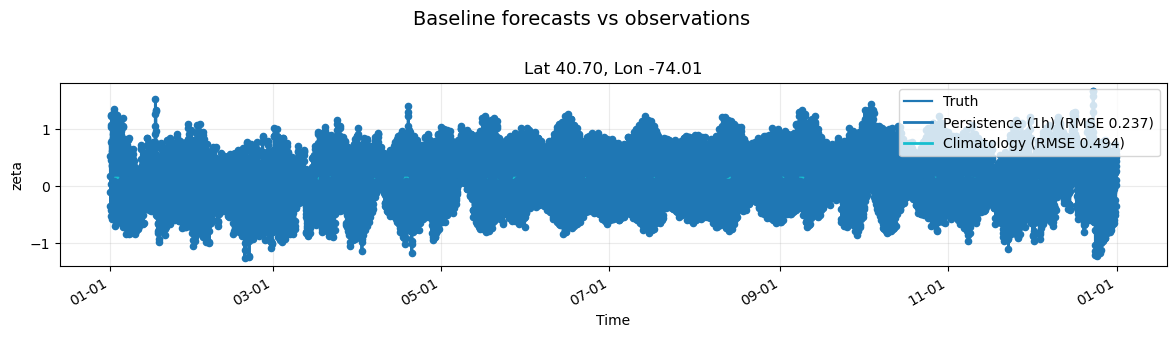

In [24]:
import matplotlib.dates as mdates

comparison_coords = [(40.70, -74.015)]
num_points = 0  # Set >0 to auto-pick sites when comparison_coords is None
time_window = ('2022-01-01', '2022-12-31')

def plot_prediction_comparison(predictions, truth, comparison_coords=None, num_points=3, time_window=None):
    pred_time_dim_candidates = []
    for arr in predictions.values():
        pred_time_dim_candidates.extend([dim for dim in arr.dims if dim in ('time', 'valid_time')])
    pred_time_dim = pred_time_dim_candidates[0] if pred_time_dim_candidates else 'time'

    if time_window:
        start, end = time_window
        truth_window = truth.sel(time=slice(start, end))
        preds_window = {name: pred.sel({pred_time_dim: slice(start, end)}) if pred_time_dim in pred.dims else pred for name, pred in predictions.items()}
    else:
        truth_window = truth
        preds_window = predictions

    aligned = xr.align(truth_window, *preds_window.values(), join='inner')
    truth_aligned = aligned[0]
    if 'valid_time' in truth_aligned.dims:
        truth_aligned = truth_aligned.rename({'valid_time': 'time'})
    preds_aligned = {}
    for name, arr in zip(preds_window.keys(), aligned[1:]):
        if 'valid_time' in arr.dims:
            arr = arr.rename({'valid_time': 'time'})
        preds_aligned[name] = arr

    if truth_aligned.sizes.get('time', 0) == 0:
        raise ValueError('No overlapping timestamps after alignment. Adjust the time window or inputs.')

    if comparison_coords:
        selected_sites = []
        for lat, lon in comparison_coords:
            site_truth = truth_aligned.sel(latitude=lat, longitude=lon, method='nearest')
            selected_sites.append((float(site_truth.latitude.values), float(site_truth.longitude.values)))
    else:
        if num_points <= 0:
            raise ValueError('Set num_points > 0 when comparison_coords is not provided.')
        first_pred = next(iter(preds_aligned.values()))
        rmse_map = np.sqrt(((first_pred - truth_aligned) ** 2).mean(dim='time'))
        rmse_series = rmse_map.to_series().dropna()
        top_sites = rmse_series.nlargest(num_points)
        selected_sites = [tuple(map(float, idx)) for idx in top_sites.index]

    fig, axes = plt.subplots(len(selected_sites), 1, figsize=(12, 3.4 * len(selected_sites)), sharex=True)
    if len(selected_sites) == 1:
        axes = [axes]

    pred_items = list(preds_aligned.items())
    colors = plt.cm.tab10(np.linspace(0, 1, len(pred_items)))

    for ax, (lat, lon) in zip(axes, selected_sites):
        truth_site = truth_aligned.sel(latitude=lat, longitude=lon, method='nearest')
        pred_sites = [arr.sel(latitude=lat, longitude=lon, method='nearest') for _, arr in pred_items]
        aligned_site = xr.align(truth_site, *pred_sites, join='inner')
        truth_site_aligned = aligned_site[0]
        pred_sites_aligned = aligned_site[1:]

        data_vars = {'Truth': truth_site_aligned}
        site_rmse = {}
        for (name, _), pred_da in zip(pred_items, pred_sites_aligned):
            data_vars[name] = pred_da
            site_rmse[name] = float(np.sqrt(((pred_da - truth_site_aligned) ** 2).mean().values))

        site_ds = xr.Dataset(data_vars)
        df = site_ds.to_dataframe().reset_index()
        for col in ('latitude', 'longitude'):
            if col in df:
                df = df.drop(columns=col)
        df = df.dropna(subset=['Truth']).sort_values('time')

        if df.empty:
            ax.text(0.5, 0.5, 'No overlapping timestamps', transform=ax.transAxes, ha='center', va='center')
            continue

        ax.plot(df['time'], df['Truth'], label='Truth', color='#1f77b4', linewidth=1.6)
        ax.scatter(df['time'], df['Truth'], color='#1f77b4', s=20, zorder=3)

        for color, (name, _), _ in zip(colors, pred_items, pred_sites_aligned):
            ax.plot(df['time'], df[name], label=f"{name} (RMSE {site_rmse[name]:.3f})", linewidth=2, color=color)
            ax.fill_between(df['time'], df['Truth'], df[name], color=color, alpha=0.12)

        ax.set_title(f'Lat {lat:.2f}, Lon {lon:.2f}')
        ax.set_ylabel(TARGET_VAR)
        ax.grid(True, which='major', alpha=0.25)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    axes[0].legend(loc='upper right')
    axes[-1].set_xlabel('Time')
    fig.autofmt_xdate()
    fig.suptitle('Baseline forecasts vs observations', y=0.98, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    return {
        'truth_window': truth_aligned,
        'preds_window': preds_aligned,
        'selected_sites': selected_sites,
        'pred_time_dim': 'time',
    }

comparison_result = plot_prediction_comparison(
    baseline_predictions,
    truth,
    comparison_coords=comparison_coords,
    num_points=num_points,
    time_window=time_window,
)


In [28]:
# !pip install ipywidgets
# !pip install nbformat

In [29]:
from ipywidgets import interact, widgets
import plotly.graph_objects as go

truth_window = comparison_result['truth_window']
preds_window = comparison_result['preds_window']
selected_sites = comparison_result['selected_sites']
pred_time_dim = comparison_result['pred_time_dim']

# Prefer manually supplied coordinates; otherwise reuse the automatically selected ones
if comparison_coords:
    interactive_locations = list(comparison_coords)
else:
    interactive_locations = list(selected_sites)

if not interactive_locations:
    raise ValueError('No locations available for the interactive comparison widget.')

def _prepare_timeseries(lat, lon):
    truth_pt = truth_window.sel(latitude=lat, longitude=lon, method='nearest', drop=True)
    series = {'Truth': truth_pt}
    for name, pred in preds_window.items():
        series[name] = pred.sel(latitude=lat, longitude=lon, method='nearest', drop=True)
    combined = xr.Dataset(series)
    df = combined.to_dataframe().reset_index().dropna()
    if pred_time_dim in df:
        df = df.rename(columns={pred_time_dim: 'time'})
    return df

def _label(lat, lon):
    return f'Lat {lat:.2f}°, Lon {lon:.2f}°'

options = [(_label(lat, lon), idx) for idx, (lat, lon) in enumerate(interactive_locations)]

@interact(location=widgets.Dropdown(options=options, description='Location'))
def show_interactive(location=0):
    lat, lon = interactive_locations[location]
    df = _prepare_timeseries(lat, lon)
    label = _label(lat, lon)
    fig = go.Figure()
    if df.empty:
        fig.update_layout(
            title=f'{label} — no overlapping timestamps',
            xaxis_title='Time',
            yaxis_title=TARGET_VAR,
        )
        fig.show()
        return

    fig.add_trace(go.Scatter(x=df['time'], y=df['Truth'], mode='lines+markers', name='Truth'))
    for name in preds_window.keys():
        fig.add_trace(
            go.Scatter(
                x=df['time'],
                y=df[name],
                mode='lines+markers',
                name=name,
            )
        )
    fig.update_layout(
        title=f'Interactive Comparison | {label}',
        xaxis_title='Time',
        yaxis_title=TARGET_VAR,
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    )
    fig.show()


interactive(children=(Dropdown(description='Location', options=(('Lat 40.70°, Lon -74.02°', 0),), value=0), Ou…

# The End

This is the end of the quickstart guide. Please refer to the Jupyter notebooks in the `notebooks` directory for more examples. If you have questions, feel free to ask them as a Github Issue.